In [2]:
import pandas as pd

ticket_data = pd.read_csv('ticket_data.csv')
cities = pd.read_csv('cities.csv')
stations = pd.read_csv('stations.csv')
providers = pd.read_csv('providers.csv')




Lecture et cration d'un objet DataFrame pour chaque fichier


---



---



In [3]:
ticket_data['price_in_euros'] = ticket_data['price_in_cents'] / 100

min_price = ticket_data['price_in_euros'].min()
avg_price = ticket_data['price_in_euros'].mean()
max_price = ticket_data['price_in_euros'].max()

print(f"Minimum price: {min_price:.2f} euros")
print(f"Average price: {avg_price:.2f} euros")
print(f"Maximum price: {max_price:.2f} euros")

Minimum price: 3.00 euros
Average price: 43.83 euros
Maximum price: 385.50 euros


Calcul du prix min, moyen et max

---



---

# Nouvelle section


In [4]:
ticket_data = pd.merge(ticket_data, cities, left_on='o_city', right_on='id', how='left')
ticket_data = ticket_data.rename(columns={'local_name': 'o_city_local_name', 'unique_name': 'o_city_name', 'latitude': 'o_latitude', 'longitude': 'o_longitude', 'population': 'o_population'})
ticket_data = pd.merge(ticket_data, cities, left_on='d_city', right_on='id', how='left')
ticket_data = ticket_data.rename(columns={'local_name': 'd_city_local_name', 'unique_name': 'd_city_name', 'latitude': 'd_latitude', 'longitude': 'd_longitude', 'population': 'd_population'})


Jointure gauche entre les tables ticket_data et cities avec les prédicats ville d'arrivée et ville de départ et on renomme certaines colonnes pour garder la cohérence dans le DatFrame

---



---



In [5]:
ticket_data = pd.merge(ticket_data, stations, left_on='o_station', right_on='id', how='left')
ticket_data = ticket_data.rename(columns={'unique_name': 'o_station_name', 'latitude': 'o_station_latitude', 'longitude': 'o_station_longitude'})
ticket_data = pd.merge(ticket_data, stations, left_on='d_station', right_on='id', how='left')
ticket_data = ticket_data.rename(columns={'unique_name': 'd_station_name', 'latitude': 'd_station_latitude', 'longitude': 'd_station_longitude'})


<ipython-input-5-b1335530726a>:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  ticket_data = pd.merge(ticket_data, stations, left_on='o_station', right_on='id', how='left')


Jointure gauche entre les tables ticket_data et stations avec les prédicats ville d'arrivée et ville de départ et on renomme certaines colonnes pour garder la cohérence dans le DatFrame

---



---



In [6]:
ticket_data = pd.merge(ticket_data, providers, left_on='company', right_on='company_id', how='left')


<ipython-input-6-f5299c318841>:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  ticket_data = pd.merge(ticket_data, providers, left_on='company', right_on='company_id', how='left')


Jointure gauche entre les tables ticket_data et providers avec le prédicat company

---



---





In [7]:
ticket_data['departure_ts'] = pd.to_datetime(ticket_data['departure_ts'])
ticket_data['arrival_ts'] = pd.to_datetime(ticket_data['arrival_ts'])
ticket_data['search_ts'] = pd.to_datetime(ticket_data['search_ts'])


Conversion des chaines de caractères en datatime pour pouvoir faire des opérations sur ces données par la suite 

---



---



In [8]:
ticket_data['duration'] = ticket_data['arrival_ts'] - ticket_data['departure_ts']

Calcul de la durée du trajet en ajoutant une nouvelle colonne duration dans le DataFrame

---



---



In [9]:
import geopy.distance

def get_distance(row):
    coords_1 = (row['o_latitude'], row['o_longitude'])
    coords_2 = (row['d_latitude'], row['d_longitude'])
    return geopy.distance.geodesic(coords_1, coords_2).km

ticket_data['distance'] = ticket_data.apply(get_distance, axis=1)

Calcul de la distance entre les deux villes en ajoutant une nouvelle colonne distance dans le DataFrame

---



---



In [10]:
avg_duration = ticket_data.groupby('distance')['duration'].mean()
min_duration = ticket_data.groupby('distance')['duration'].min()
max_duration = ticket_data.groupby('distance')['duration'].max()
print(avg_duration)
print(min_duration)
print(avg_duration)



distance
18.962318               0 days 00:50:00
19.278224               0 days 02:07:00
20.183667               0 days 06:07:40
21.437098               0 days 06:48:48
24.303780     0 days 01:51:34.736842105
                         ...           
1669.041405             1 days 02:00:00
1709.255369   1 days 16:32:20.362438220
1755.788026   1 days 12:56:10.588235294
1760.189271   4 days 23:28:10.841584158
1875.174971             1 days 23:30:00
Name: duration, Length: 1182, dtype: timedelta64[ns]
distance
18.962318     0 days 00:50:00
19.278224     0 days 01:56:00
20.183667     0 days 01:42:00
21.437098     0 days 01:34:00
24.303780     0 days 00:57:00
                    ...      
1669.041405   1 days 02:00:00
1709.255369   1 days 04:40:00
1755.788026   0 days 17:00:00
1760.189271   1 days 14:00:00
1875.174971   1 days 23:30:00
Name: duration, Length: 1182, dtype: timedelta64[ns]
distance
18.962318               0 days 00:50:00
19.278224               0 days 02:07:00
20.183667        

Calcul de la durée min, max, moyenne par trajet

---



---



In [11]:
def distance_range(distance):
    if distance <= 200:
        return '0-200km'
    elif distance <= 800:
        return '201-800km'
    elif distance <= 2000:
        return '801-2000km'
    else:
        return '2000+km'

ticket_data['distance_range'] = ticket_data['distance'].apply(distance_range)

 Catégorisation de la distance en quatre tranches

---



---



In [12]:


def get_avg_price_duration_by_distance_and_transport(df):

    
    distance_ranges = [(0, 200), (201, 800), (801, 2000), (2001, df['distance'].max())]
    transport_modes = ['train', 'bus', 'carpooling']
    results = {}

   
    for distance_range in distance_ranges:

        distance_min, distance_max = distance_range

        distance_filter = (df['distance'] >= distance_min) & (df['distance'] <= distance_max)
        df_filtered = df[distance_filter]

        
        for transport_mode in transport_modes:

            transport_filter = df_filtered['transport_type'] == transport_mode
            df_transport_filtered = df_filtered[transport_filter]

            avg_price = df_transport_filtered['price_in_cents'].mean() / 100
            avg_duration = df_transport_filtered['duration'].mean()

            key = f'{distance_min}-{distance_max} km {transport_mode}'
            results[key] = {'avg_price': avg_price, 'avg_duration': avg_duration}

    return results

results = get_avg_price_duration_by_distance_and_transport(ticket_data)
print(results)


{'0-200 km train': {'avg_price': nan, 'avg_duration': NaT}, '0-200 km bus': {'avg_price': 20.938805970149257, 'avg_duration': Timedelta('0 days 10:05:32.238805970')}, '0-200 km carpooling': {'avg_price': 19.9, 'avg_duration': Timedelta('0 days 14:15:00')}, '201-800 km train': {'avg_price': 32.65555555555556, 'avg_duration': Timedelta('0 days 12:42:13.333333333')}, '201-800 km bus': {'avg_price': 32.85911794293658, 'avg_duration': Timedelta('0 days 14:00:49.501613731')}, '201-800 km carpooling': {'avg_price': 43.385, 'avg_duration': Timedelta('0 days 10:36:15')}, '801-2000 km train': {'avg_price': nan, 'avg_duration': NaT}, '801-2000 km bus': {'avg_price': 61.12710280373832, 'avg_duration': Timedelta('1 days 00:25:07.009345794')}, '801-2000 km carpooling': {'avg_price': nan, 'avg_duration': NaT}, '2001-1875.1749712829258 km train': {'avg_price': nan, 'avg_duration': NaT}, '2001-1875.1749712829258 km bus': {'avg_price': nan, 'avg_duration': NaT}, '2001-1875.1749712829258 km carpooling': 

Différence de prix moyen et durée selon le train, le bus et le covoit selon la distance du trajet 

---



---



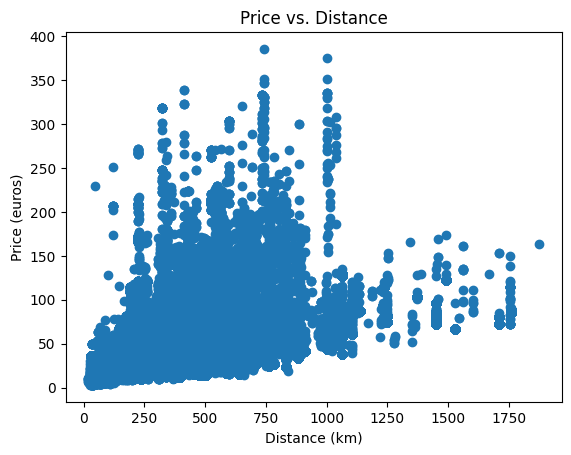

In [13]:
# create a scatter plot of distance vs. price
import matplotlib.pyplot as plt
plt.scatter(ticket_data['distance'], ticket_data['price_in_euros'])
plt.xlabel('Distance (km)')
plt.ylabel('Price (euros)')
plt.title('Price vs. Distance')
plt.show()

Graphique relation entre le prix et la distance 

---



---



In [14]:
# create a linear regression model to predict price based on distance
from sklearn.linear_model import LinearRegression
X = ticket_data['distance'].values.reshape(-1, 1)
y = ticket_data['price_in_euros'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print('Price prediction for 1000km distance:', reg.predict([[1000]])[0][0])

Price prediction for 1000km distance: 61.36968708693557


prédiction du prix d'un billet pour une distance de 1000 km en utilisant la régression linéaire

---



---



---

